## **Модель машинного обучения**
### Построим множественную регрессию для прогнозирования цен на квартиры в Москве

## **Импорт библиотек**

In [1]:
import pandas as pd #библиотека для обработки и анализа данных в виде таблиц
import numpy as np #библиотека, добавляющая поддержку больших многомерных массивов и матриц, вместе с большой библиотекой высокоуровневых математических функций для операций с этими массивами

#scikit-learn — это библиотека, предназначенная для машинного обучения
from sklearn.linear_model import LinearRegression #линейная регрессия
from sklearn import preprocessing #предоставляет функции для преобразования данных в более подходящий вид для последующих оценок

import statsmodels.api as sm #позволяет исследовать данные, оценивать статистические модели и выполнять статистические тесты
import scipy.stats as stats
import seaborn as sns #эта библиотека предназначена для создания статистических графиков

from pyhive import hive

## **Подключение к базе данных и импорт данных**

In [2]:
#mart2 = pd.read_csv('mart2.csv')
conn = hive.Connection(host='localhost', port=10000, database='project')
cursor = conn.cursor()
query = "SELECT * FROM mart_2"
mart2 = pd.read_sql(query, conn)
conn.close()

/tmp/ipykernel_24907/2214197992.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  mart2 = pd.read_sql(query, conn)


In [3]:
mart2.head()

,mart_2.id,mart_2.price,mart_2.address,mart_2.district,mart_2.rooms,mart_2.current_floor,mart_2.max_floor,mart_2.build_year,mart_2.bath,mart_2.repair,mart_2.window_type,mart_2.total,mart_2.street,mart_2.kills,mart_2.harm,mart_2.theft,mart_2.robbery,mart_2.brigandage,mart_2.cameras
0,2,6000000.0,Москва ЗАО р-н Очаково-Матвеевское Аминьевское...,Очаково-Матвеевское,1.0,6.0,16.0,1976.0,1 раздельный,Косметический,Во двор,917.0,240.0,NaN,9.0,NaN,NaN,NaN,896
1,4,5450000.0,Москва ЮЗАО р-н Ясенево Голубинская ул. 7К5,Ясенево,NaN,1.0,9.0,1976.0,1 совмещенный,Евроремонт,На улицу и двор,798.0,NaN,1.0,NaN,NaN,21.0,NaN,733
2,5,5340000.0,Москва ЮЗАО р-н Коньково Профсоюзная ул. 73,Коньково,1.0,5.0,15.0,1973.0,1 раздельный,Без ремонта,,923.0,225.0,1.0,4.0,457.0,12.0,4.0,883
3,6,6230000.0,Москва ВАО р-н Богородское Ивантеевская ул. 9А,Богородское,NaN,2.0,5.0,1955.0,1 совмещенный,Дизайнерский,,876.0,211.0,3.0,NaN,429.0,15.0,NaN,1353
4,7,6960000.0,Москва ВАО р-н Богородское Ивантеевская ул. 9А,Богородское,NaN,2.0,5.0,1955.0,1 совмещенный,Дизайнерский,,876.0,211.0,3.0,NaN,429.0,15.0,NaN,1353


## **Очищение и преобразование данных**

**Выброс** — это наблюдение, которое лежит аномально далеко от других значений в наборе данных. Выбросы могут быть проблематичными, поскольку они могут повлиять на результаты анализа.
Для удаления выбросов будем использовать межквартильный диапазон.

**Межквартильный размах (IQR)** — это разница между 75-м процентилем (Q3) и 25-м процентилем (Q1) в наборе данных. Он измеряет разброс средних 50% значений.
Можно определить наблюдение как выброс, если оно в 1,5 раза превышает межквартильный размах, превышающий третий квартиль (Q3), или в 1,5 раза превышает межквартильный размах, меньше первого квартиля (Q1).
Выбросы = наблюдения > Q3 + 1,5*IQR или Q1 – 1,5*IQR

In [158]:
mart2.dropna(subset=['mart_2.price'], inplace=True)
q3, q1 = np.percentile(mart2['mart_2.price'], [75, 25]) #получаем 75-й и 25-й процентили колонки price
IQR = q3 - q1 #рассчитываем межквартильный размах
upper_bound = q3 + 1.5 * IQR #получаем высшую границу
lower_bound = q1 - 1.5 * IQR #получаем низшую границу

mart2 = mart2[(mart2['mart_2.price'] < upper_bound) & (mart2['mart_2.price'] > lower_bound)] #выбираем только те записи, у которых цена находится в пределах границ

In [94]:
#линейная регрессия не может работать со строками, их нужно заменить на числовые значения
le = preprocessing.LabelEncoder() #(Кодирование меток) - метод, который присваивает каждому уникальному значению категориального признака уникальное целочисленное значение
le.fit(mart2['mart_2.district'])
mart2['district_num'] = le.transform(mart2['mart_2.district']) #создание нового столбца с замененными строковыми данными на целочисленные

le2 = preprocessing.LabelEncoder()
le2.fit(mart2['mart_2.repair'])
mart2['repair_num'] = le2.transform(mart2['mart_2.repair'])

le3 = preprocessing.LabelEncoder()
le3.fit(mart2['mart_2.window_type'])
mart2['window_num'] = le3.transform(mart2['mart_2.window_type'])

Выбираем нужные столбцы и удаляем записи с пропущенными значениями

In [6]:
model_data = mart2.loc[:, ['mart_2.price', 'district_num', 'mart_2.rooms', 'mart_2.current_floor', 'mart_2.build_year', 'repair_num', 'window_num']].dropna()

## **Множественная регрессия**

Проверяем данные на мультиколлинеарность, так как для линейной регрессии атрибуты не должны иметь связи

<Axes: >

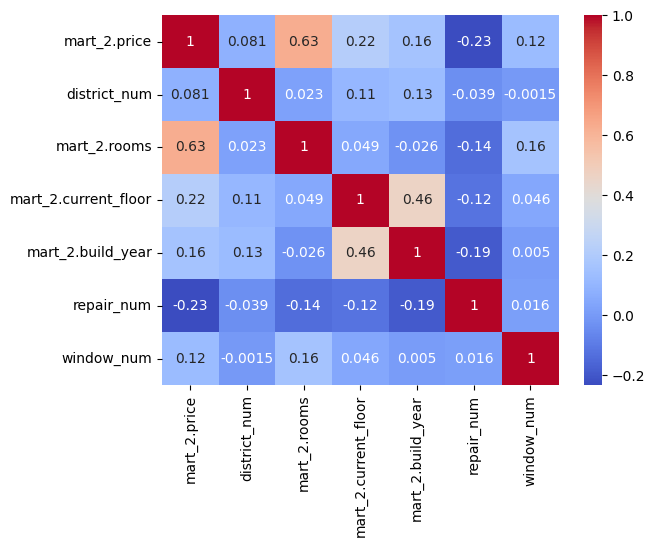

In [7]:
sns.heatmap(model_data.corr(), annot=True, cmap='coolwarm')

In [190]:
#X = model_data.loc[:, ['district_num', 'mart_2.rooms', 'mart_2.current_floor', 'mart_2.build_year', 'repair_num', 'window_num']] #В качестве X выбираем независимые переменные

model_data = mart2.loc[:, ['mart_2.price', 'mart_2.district', 'mart_2.rooms', 'mart_2.current_floor', 'mart_2.build_year', 'mart_2.repair',
                          'mart_2.window_type']].dropna()
X = pd.get_dummies(data = model_data.loc[:, ['mart_2.district', 'mart_2.rooms', 'mart_2.current_floor', 'mart_2.build_year', 'mart_2.repair',
                                            'mart_2.window_type']], drop_first=True)
Y = model_data['mart_2.price'] #В качестве Y выбираем зависимую переменную, в нашем случае, цену
X

,mart_2.rooms,mart_2.current_floor,mart_2.build_year,mart_2.district_Алексеевский,mart_2.district_Алтуфьевский,mart_2.district_Арбат,mart_2.district_Аэропорт,mart_2.district_Бабушкинский,mart_2.district_Басманный,mart_2.district_Беговой,...,mart_2.repair_Дизайнерский,mart_2.repair_Евроремонт,mart_2.repair_Косметический,mart_2.window_type_Без ремонта,mart_2.window_type_Во двор,mart_2.window_type_Дизайнерский,mart_2.window_type_Евроремонт,mart_2.window_type_Косметический,mart_2.window_type_На улицу,mart_2.window_type_На улицу и двор
0,1.0,6.0,1976.0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,1.0,5.0,1973.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
512,1.0,1.0,1955.0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
513,1.0,3.0,1955.0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
514,1.0,3.0,1955.0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25056,5.0,4.0,2013.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
25057,5.0,7.0,1914.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
25058,5.0,12.0,2012.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
25059,5.0,18.0,2014.0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0


Строим множественную регрессию

In [36]:
print(le.transform(['Хамовники', 'Раменки']))
print(le2.transform(['Дизайнерский']))

[102  79]
[6]


In [191]:
reg = LinearRegression().fit(X, Y)
reg.score(X, Y)

0.5336407393470721

In [213]:
test_hamovkini = X[0:1]
test_ramenki = X[0:1]

In [214]:
for col in test_hamovkini:
    test_hamovkini[col].values[:] = 0
test_hamovkini.loc[0, ['mart_2.rooms']] = 4
test_hamovkini.loc[0, ['mart_2.current_floor']] = 10
test_hamovkini.loc[0, ['mart_2.build_year']] = 2022
test_hamovkini.loc[0, ['mart_2.district_Хамовники']] = 1
test_hamovkini.loc[0, ['mart_2.repair_Дизайнерский']] = 1
test_hamovkini.loc[0, ['mart_2.window_type_Во двор']] = 1

In [215]:
reg.predict(test_hamovkini)[0]

201032751.32685804

In [221]:
for col in test_ramenki:
    test_ramenki[col].values[:] = 0
test_ramenki.loc[0, ['mart_2.rooms']] = 4
test_ramenki.loc[0, ['mart_2.current_floor']] = 10
test_ramenki.loc[0, ['mart_2.build_year']] = 2022
test_ramenki.loc[0, ['mart_2.district_Раменки']] = 1
test_ramenki.loc[0, ['mart_2.repair_Дизайнерский']] = 1
test_ramenki.loc[0, ['mart_2.window_type_Во двор']] = 1

In [222]:
reg.predict(test_ramenki)[0]

89656741.54127288